In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from math import sqrt
import matplotlib.pyplot as plt
from datetime import timedelta
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller
rcParams['figure.figsize'] = 8,6
rcParams['font.family'] = 'serif'
import seaborn as sb
pd.set_option('min_rows',800)
sb.set()

### Addition to the Mean Reversion Trading Strategy
It would also be insightful to do an ADF (Augmented Dickey-Fuller) Test on SPY to see if it is an optimal indicator to perform this strategy on
> __Objective__ To check if a time series is stationary

In [2]:
SPY = yf.download(['SPY'],'2020-1-1')
del SPY['Volume']
del SPY['High']
del SPY['Low']
del SPY['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [3]:
result = adfuller(SPY['Close'].dropna())
print('ADF Statistic:',result[0])
print('p-value:',result[1])
print("Critical Values:",result[4])

ADF Statistic: -0.6504706633799245
p-value: 0.8591651789513037
Critical Values: {'1%': -3.4361864296062166, '5%': -2.864117116658563, '10%': -2.5681421294173714}


<div class="alert alert-block alert-warning">
The ADF statistic of -0.6504706633799245 is not more negative than any of the critical values.
The p-value of 0.8591651789513037 is much higher than the typical significance level of 0.05.
Based on these results, you fail to reject the null hypothesis that the time series has a unit root. This implies that the time series is non-stationary, meaning its statistical properties such as mean, variance, and autocorrelation are not constant over time.
</div>

Therefore initially without doing this test, I got a Cumulative PnL of $8.21, i would try to make the series stationary and then see if it has any impact on the total PnL

In [4]:
SPY['Close_Diff'] = SPY['Close'].diff()
result_diff = adfuller(SPY['Close_Diff'].dropna())
print('ADF Statistic:',result_diff[0])
print('p-value:',result_diff[1])
print("Critical Values:",result_diff[4])

ADF Statistic: -10.210486248323837
p-value: 5.655365193297729e-18
Critical Values: {'1%': -3.4361864296062166, '5%': -2.864117116658563, '10%': -2.5681421294173714}


In [10]:
window = 20
SPY['Rolling Mean'] = SPY['Close'].rolling(window=window).mean()
SPY['Rolling Std'] = SPY['Close'].rolling(window=window).std().

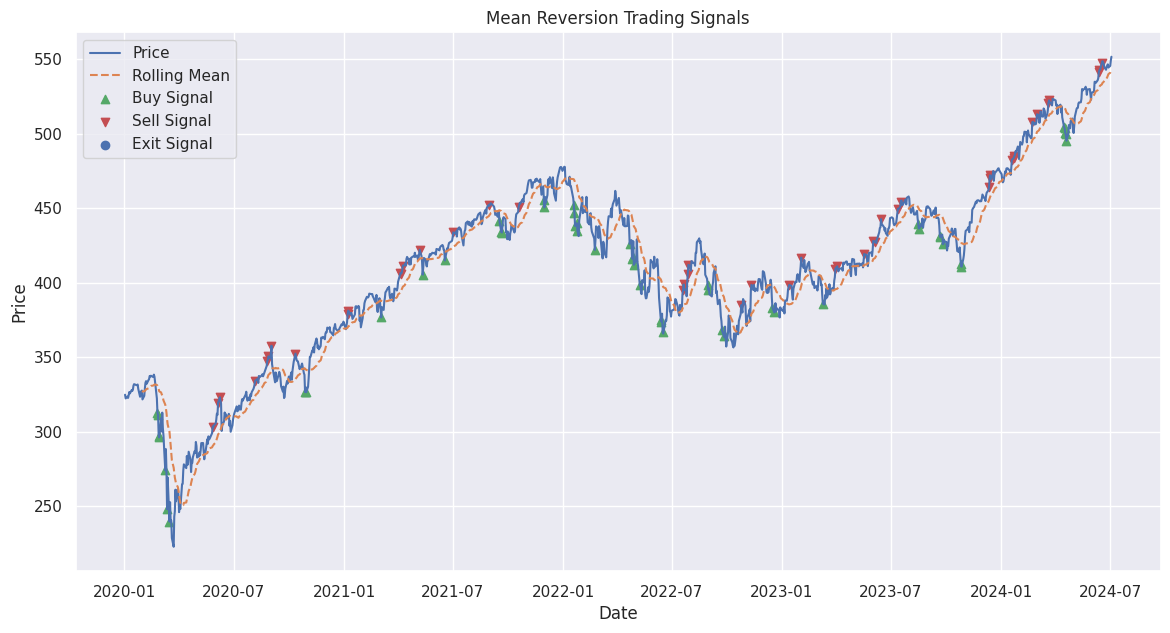

In [11]:
SPY['Z-Score'] = (SPY['Close'] - SPY['Rolling Mean']) / SPY['Rolling Std']

# Define trading signals
entry_threshold = 2
exit_threshold = 0

SPY['Buy Signal'] = SPY['Z-Score'] < -entry_threshold
SPY['Sell Signal'] = SPY['Z-Score'] > entry_threshold
SPY['Exit Signal'] = SPY['Z-Score'].abs() < exit_threshold

# Plot the time series and signals
plt.figure(figsize=(14, 7))
plt.plot(SPY.index, SPY['Close'], label='Price')
plt.plot(SPY.index, SPY['Rolling Mean'], label='Rolling Mean', linestyle='--')
plt.scatter(SPY.index[SPY['Buy Signal']], SPY['Close'][SPY['Buy Signal']], label='Buy Signal', marker='^', color='g')
plt.scatter(SPY.index[SPY['Sell Signal']], SPY['Close'][SPY['Sell Signal']], label='Sell Signal', marker='v', color='r')
plt.scatter(SPY.index[SPY['Exit Signal']], SPY['Close'][SPY['Exit Signal']], label='Exit Signal', marker='o', color='b')
plt.legend()
plt.title('Mean Reversion Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [13]:
SPY.dropna()

,Open,Close,Close_Diff,Rolling Mean,Rolling Std,Z-Score,Buy Signal,Sell Signal,Exit Signal
Date,,,,,,,,,
2020-01-30,324.359985,327.679993,1.059998,327.237003,3.080404,0.143809,False,False,False
2020-01-31,327.000000,321.730011,-5.949982,327.080003,3.280886,-1.630655,False,False,False
2020-02-03,323.350006,324.119995,2.389984,327.165503,3.173299,-0.959729,False,False,False
2020-02-04,328.070007,329.059998,4.940002,327.436502,3.086626,0.525977,False,False,False
2020-02-05,332.269989,332.859985,3.799988,327.943001,3.104752,1.583697,False,False,False
2020-02-06,333.910004,333.980011,1.120026,328.419501,3.267493,1.701767,False,False,False
2020-02-07,332.820007,332.200012,-1.779999,328.697002,3.344081,1.047526,False,False,False
2020-02-10,331.230011,334.679993,2.479980,329.145502,3.519312,1.572606,False,False,False
2020-02-11,336.160004,335.260010,0.580017,329.511002,3.759981,1.528999,False,False,False


We need to quantitatively calculate the PnL for this method

In [27]:
TradeBook = pd.DataFrame(index=SPY.index)
TradeBook['Position'] = 0
TradeBook['Price Bought'] = 0.0
TradeBook['Price Sold'] = 0.0
for i in range(1,len(SPY)):
    if SPY['Buy Signal'].iloc[i-1] == True:
        TradeBook['Position'].iloc[i-1] += 1
        TradeBook['Price Bought'].iloc[i-1] += SPY['Close'].iloc[i-1]
    if SPY['Sell Signal'].iloc[i-1] == True:
        TradeBook['Position'].iloc[i-1] -=  1
        TradeBook['Price Sold'].iloc[i-1] -= SPY["Close"].iloc[i-1]
TradeBook['Total Position Left'] = TradeBook['Position'].cumsum()
TradeBook['Total Bought'] = TradeBook['Price Bought'].cumsum()
TradeBook['Total Sold'] = TradeBook['Price Sold'].cumsum()
print(f"Positions Left: {TradeBook['Total Position Left'][-1]}, with PnL {TradeBook['Total Bought'][-1]+TradeBook['Total Sold'][-1]}")

Positions Left: 4, with PnL 393.94007873535156


/tmp/ipykernel_18602/3516984010.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  TradeBook['Position'].iloc[i-1] += 1
/tmp/ipykernel_18602/3516984010.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D